In [2]:
#import tensorflow as tf
#import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk

import re
import os

### Actions performed
#### Prototype how to load the wall street journal data. 
#### Evaluation methods to compare trees
#### comparison with google word vectors and convert words which are not there to UNK or some other symbol
#### Filters sentences which are more than MAX_WORDS_COUNT words. Made the sentence equal to length MAX_WORDS_COUNT by adding &lt; /fill &gt; word

# Load training and test dataset

#### Use BracketParse corpus reader to load the wall street journal data
#### functions subtrees(), label(), leaves() are important
#### checkout load-penn-treebank-dataset.py for protoypes

In [3]:
dirname = os.getcwd()
dirname = os.path.dirname(dirname)
dataset_path = os.path.join(dirname, 'datasets/')
print(dataset_path)

/media/kandy/hdd/master-thesis/constituency-parsing/datasets/


In [4]:
## https://www.nltk.org/_modules/nltk/tree.html
## http://www.nltk.org/howto/tree.html
## above link contains the API and also some tutorials

#reader = nltk.corpus.BracketParseCorpusReader('.','SWB-all-sentences-original-with-punctuation.MRG')
reader = nltk.corpus.BracketParseCorpusReader(dataset_path,'WSJ.txt')
print(reader.fileids())
print(type(reader))

## reads the file and converts each line into a tree
all_trees = reader.parsed_sents()
print('No. of trees: ', len(all_trees))
print(type(all_trees[0]))

['WSJ.txt']
<class 'nltk.corpus.reader.bracket_parse.BracketParseCorpusReader'>
No. of trees:  49208
<class 'nltk.tree.Tree'>


In [5]:
def get_frequency(trees):
    frequency_dict = {}
    for tree in trees:
        words = tree.leaves()
        words = [word.lower() for word in words]
        for word in words:
            if word not in frequency_dict.keys():
                frequency_dict[word] = 0
            frequency_dict[word] = frequency_dict[word] + 1
    return frequency_dict

def filter_trees(trees, threshold_value, frequency_dict):
    filtered_trees = []
    
    if(frequency_dict is None):
        frequency_dict = get_frequency(trees)
    
    print('No.of words: ',len(frequency_dict))
    keys = list(frequency_dict.keys())
    for key in keys:
        if(frequency_dict[key] <= threshold_value) :
            frequency_dict.pop(key, None)
    print('No. of words whose frequency is more than ',threshold_value,' is:', len(frequency_dict))
    
    print('No. of trees:',len(trees))
    filtered_trees = []
    for tree in trees:
        words = tree.leaves()
        words = [word.lower() for word in words]
        isFrequent = True
        for word in words:
            if word not in frequency_dict.keys():
                isFrequent = False
                break
        if(isFrequent):
            filtered_trees.append(tree)
    print('No. of filtered trees:',len(filtered_trees))
    
    return filtered_trees

FREQUENCY_THRESHOLD_VALUE = 2
frequency_dict = get_frequency(all_trees)
trees = filter_trees(all_trees, FREQUENCY_THRESHOLD_VALUE, frequency_dict)

No.of words:  44377
No. of words whose frequency is more than  2  is: 18198
No. of trees: 49208
No. of filtered trees: 28837


### Evaluation methods to compare trees
#### equality operator (==) is good enough to compare trees. When comparing both the tree and tree label is taken into account
#### Initial methods will not have categorization classification technique. So, it is important to replace all the values with say UNK symbol of google corpus
#### It is created in such a way that subcategories of punctuations are named by itself

## Preprocess Tree to chomsky normal form, collapse unary and make it UNLabelled

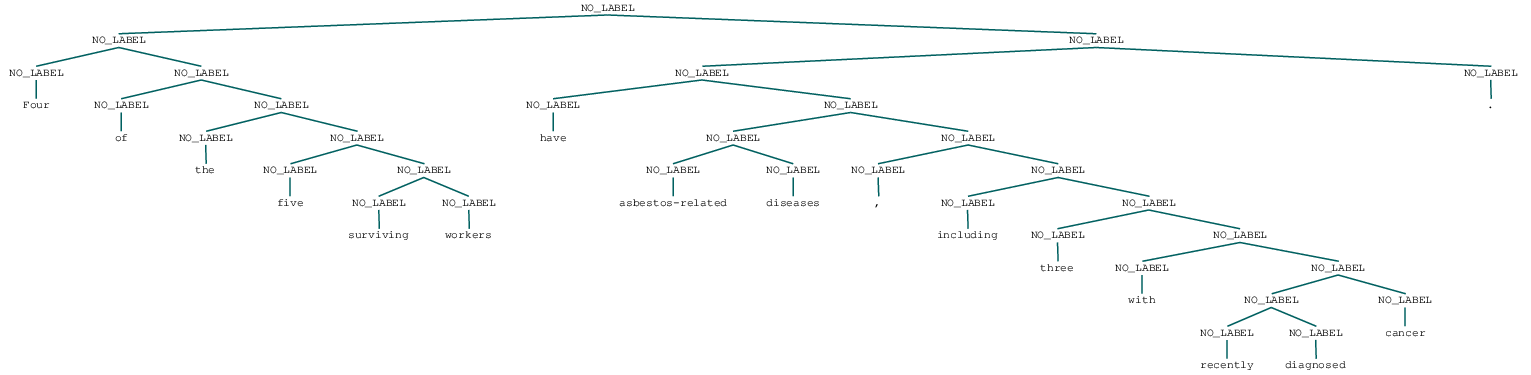

In [6]:
NO_LABEL = 'NO_LABEL'

def set_no_label(tree):
    if(type(tree[0]) == type('a string')):
        # we have reached the bottom most parent
        tree.set_label(NO_LABEL)
        return
   
    # accesses the left child
    set_no_label(tree[0])
    
    # accesses the right child
    set_no_label(tree[1])

    tree.set_label(NO_LABEL)
    

def preprocess_tree(tree):
    
    # set chomsky normal form
    tree.chomsky_normal_form()
    # merge the unary branches
    tree.collapse_unary(collapsePOS=True, collapseRoot=True)
    # set the label with 'NO_LABEL'
    set_no_label(tree)
    
#temp_trees = [preprocess_tree(tree) for tree in trees]
#temp_trees[0]
tree = trees[10]
preprocess_tree(tree)
tree

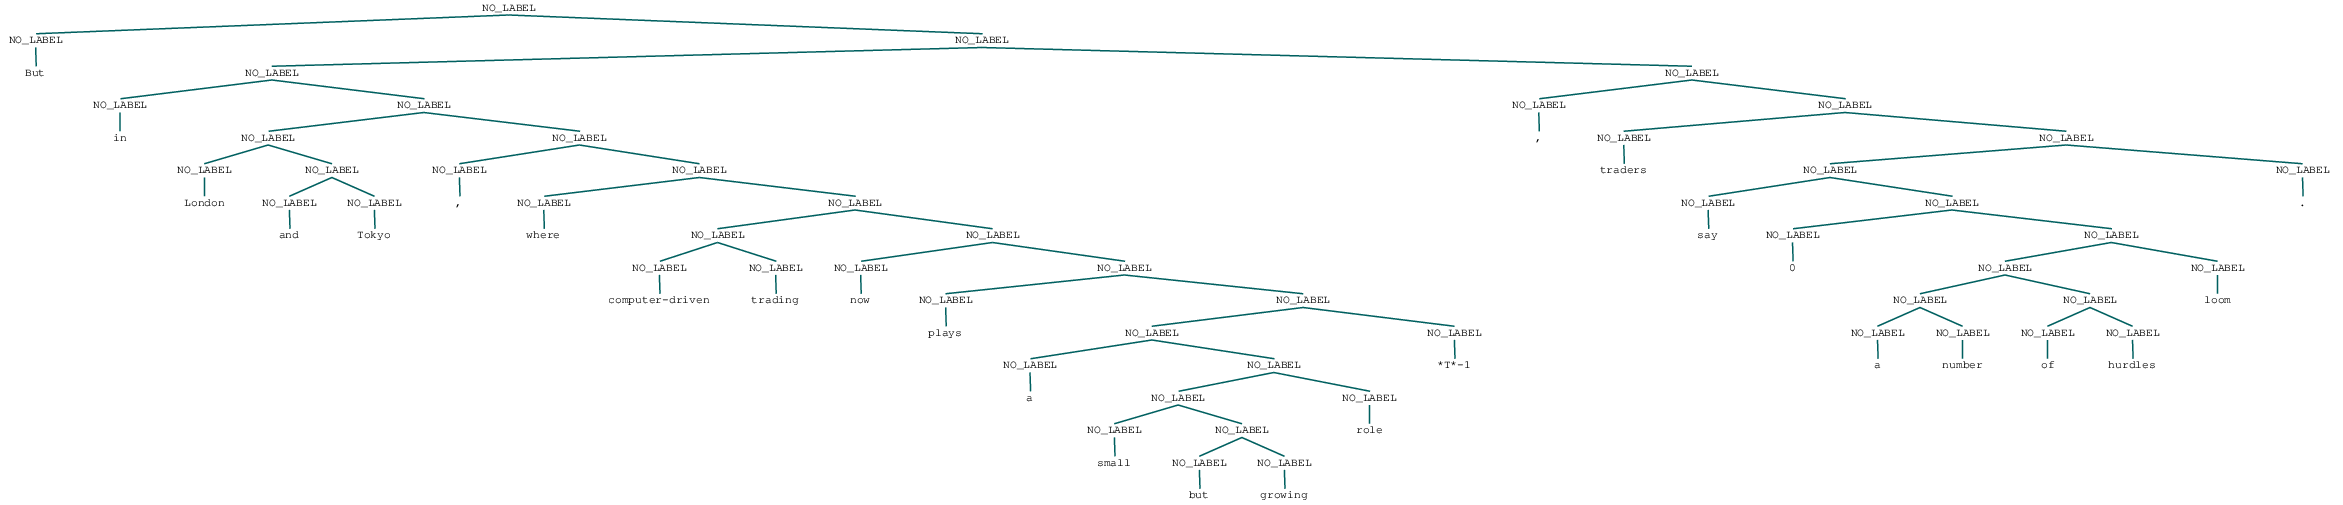

In [7]:
preprocessed_trees = []
for i in range(len(trees)):
    tree = trees[i]
    preprocess_tree(tree)
    preprocessed_trees.append(tree)
    
preprocessed_trees[1000]

### Convert the words which does not appear in Google word embeddings with UNK or other symbol
As suggested in 'check-embeddings-wallstreet-coverage' google word embeddings are better than glove embeddings

In [8]:
UNK = '</s>'
FILLER = '</fill>'

outfile = dataset_path +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
#googleSet = pd.read_csv(dataset_path+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)

#print(googleSet.shape)
#print(googleSet.head())

# TO BE DONE - Appropriate value should be added for FILLER. Right now it is a range from 1 to STATE_SIZE
#fill_data = {0:FILLER}
#for i in range(1, googleSet.shape[1]):
#    fill_data[i] = i
#googleSet = googleSet.append(fill_data, ignore_index=True)

#print(googleSet.shape)
#print(googleSet.head())

#temp = list(googleCorpus)
#temp.append(FILLER)
#googleCorpus = set(temp)
#corpus_length = len(google_corpus_word_to_int)
#google_corpus_word_to_int[FILLER] = corpus_length
#google_corpus_int_to_word[corpus_length] = FILLER


#googleWords = googleSet.iloc[:,0:1]
#googleVectors = googleSet.iloc[:,1:]

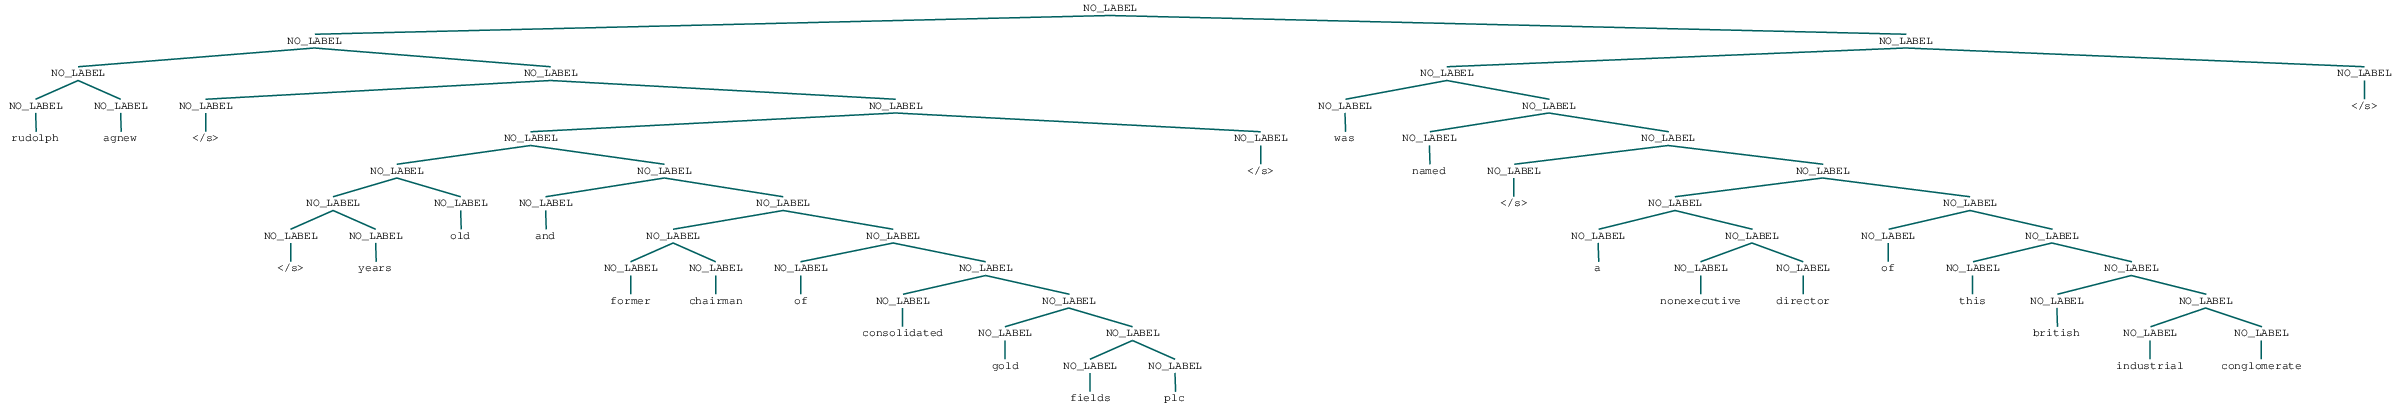

In [9]:
UNK = '</s>' # this is the symbol for UNK in google corpus

def set_UNK(tree):
    if(type(tree[0]) == type('a string')):
        # we have reached the bottom most parent
        tree[0] = tree[0].lower()
        if(tree[0] not in googleCorpus):
            tree[0] = UNK
        return
   
    # accesses the left child
    set_UNK(tree[0])
    
    # accesses the right child
    set_UNK(tree[1])
    
#temp_trees = [preprocess_tree(tree) for tree in trees]
#temp_trees[0]
tree = preprocessed_trees[0]
set_UNK(tree)
tree

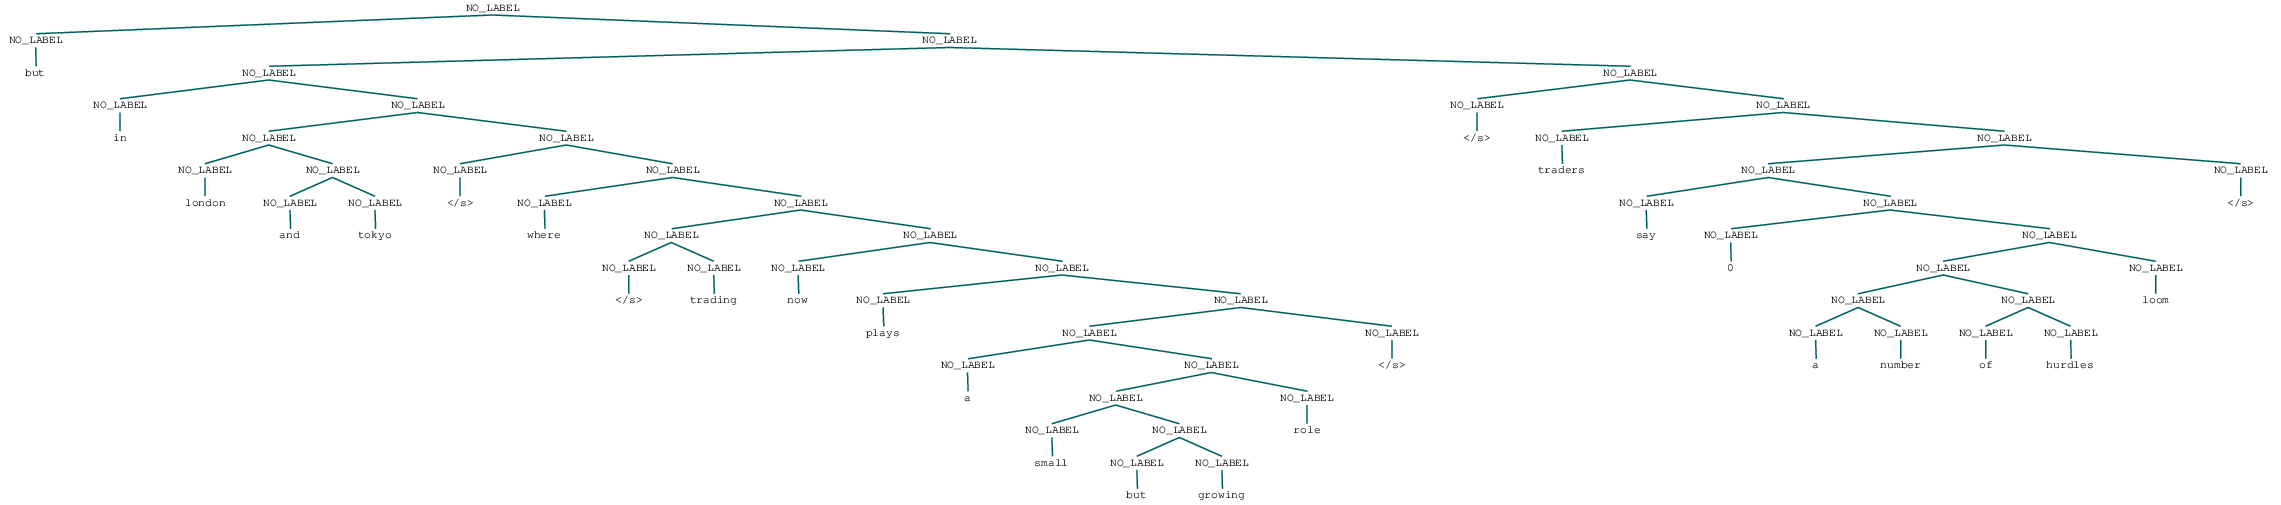

In [10]:
preprocessed_unk_trees = []
for i in range(len(preprocessed_trees)):
    tree = preprocessed_trees[i]
    set_UNK(tree)
    preprocessed_unk_trees.append(tree)
    
preprocessed_unk_trees[1000]

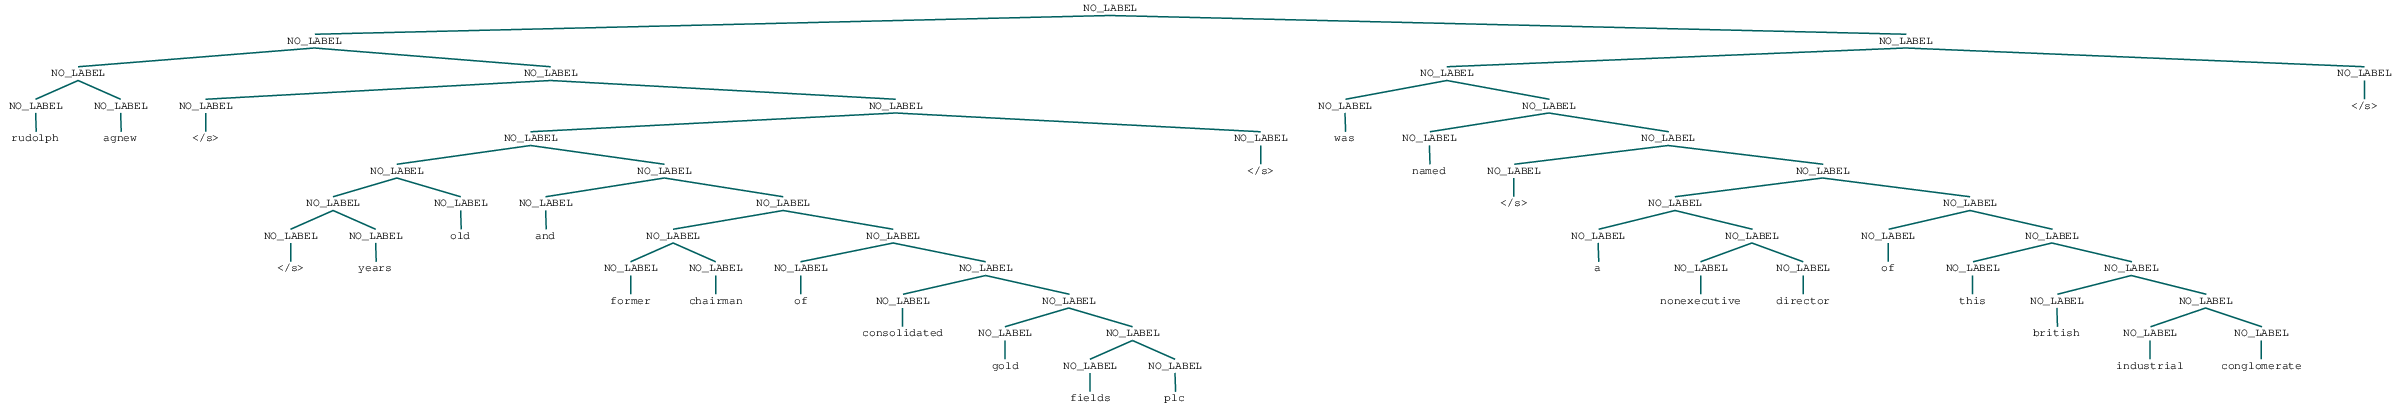

0.18518518518518517

In [11]:
def UNK_count_analysis(tree):
    words = tree.leaves()
    words_count = len(words)
    unk_count = 0
    for word in words:
        if word == UNK:
            unk_count = unk_count + 1
    #print(unk_count, words_count)
    return unk_count / words_count

display(preprocessed_unk_trees[0])
UNK_count_analysis(preprocessed_unk_trees[0])

In [12]:
THRESHOLD_PERCENTAGE = 0.25
preprocessed_unk_lt25per_trees = []
print(len(preprocessed_unk_trees))
for i in range(len(preprocessed_unk_trees)):
    tree = preprocessed_unk_trees[i]
    unk_percentage = UNK_count_analysis(tree)
    if(unk_percentage <= THRESHOLD_PERCENTAGE):
        preprocessed_unk_lt25per_trees.append(tree)
print(len(preprocessed_unk_lt25per_trees))

28837
23292


### Only sentences with <= MAX_WORDS_COUNT words (<MAX_WORDS_COUNT words suffix additional words and make it MAX_WORDS_COUNT)

23292
486


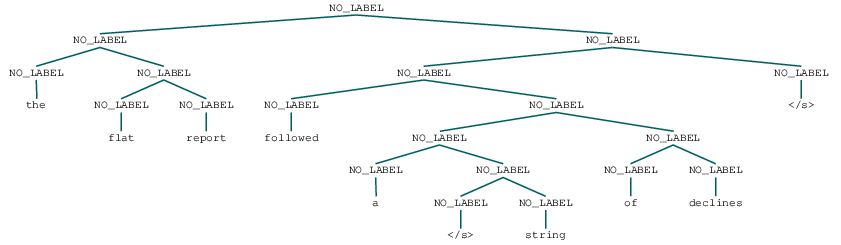

In [51]:
FILLER = '</fill>'
MAX_WORDS_COUNT = 10
preprocessed_unk_max_words_trees = []
for i in range(len(preprocessed_unk_lt25per_trees)):
    tree = preprocessed_unk_lt25per_trees[i]
    words_count = len(tree.leaves())
    if(words_count == MAX_WORDS_COUNT): # it has been changed strictly from <= to ==
        for i in range(MAX_WORDS_COUNT - words_count):
            tree = nltk.Tree(NO_LABEL, [tree, nltk.Tree(NO_LABEL, [FILLER])])
        preprocessed_unk_max_words_trees.append(tree)

print(len(preprocessed_unk_lt25per_trees))
print(len(preprocessed_unk_max_words_trees))
preprocessed_unk_max_words_trees[60] #123

In [52]:
def convert_golden_tree(tree, leaves, input_list):
    if(type(tree[0]) == type('some string')):
        #print(tree[0])
        leaveIndex = leaves.index(tree[0])
        leaves[leaveIndex]=''
        return leaveIndex
    
    leftIndex = convert_golden_tree(tree[0], leaves, input_list)
    rightIndex = convert_golden_tree(tree[1], leaves, input_list)
    #print(leftIndex, rightIndex)
    #print(leftIndex)
    input_list.append(leftIndex)
    #return len(leaves) + len(input_list)
    return leftIndex

tree_list =[]
tree_leaves = preprocessed_unk_max_words_trees[0].leaves()
convert_golden_tree(preprocessed_unk_max_words_trees[0], tree_leaves, tree_list)
tree_list

[2, 5, 4, 4, 2, 1, 8, 1, 0]

In [53]:
golden_trees_combination = []
for i in range(len(preprocessed_unk_max_words_trees)):
    tree = preprocessed_unk_max_words_trees[i]
    temp_combination = []
    tree_leaves = tree.leaves()
    convert_golden_tree(tree, tree_leaves, temp_combination)
    golden_trees_combination.append(temp_combination)
    
print(len(golden_trees_combination))

486


In [54]:
# Serialize it as CSV

treesDict = [{'sentence': ' '.join(tree.leaves()), 'tree':tree} for tree in preprocessed_unk_max_words_trees]
treeDataframe = pd.DataFrame(data=treesDict, columns=['sentence', 'tree'])
treeDataframe.head()

,sentence,tree
0,there is no asbestos in our products now </s> ...,"[[there], [[(NO_LABEL is), (NO_LABEL\n (NO_LA..."
1,it has no bearing on our work force today </s>,"[[it], [[(NO_LABEL has), (NO_LABEL\n (NO_LABE..."
2,cray computer has applied </s> to trade on nas...,"[[[cray], [computer]], [[(NO_LABEL has), (NO_L..."
3,esso said 0 the whiting field started producti...,"[[esso], [[(NO_LABEL said), (NO_LABEL\n (NO_L..."
4,they expect him to cut costs throughout the or...,"[[they], [[(NO_LABEL expect), (NO_LABEL\n (NO..."


In [55]:
treeDataframe.to_csv(dataset_path+'constituency-parsing-data-'+str(MAX_WORDS_COUNT)+'-UNK-NOLABEL.csv', sep=' ', index=False, header=False)

In [56]:
load_treeData = pd.read_csv(dataset_path+'constituency-parsing-data-'+str(MAX_WORDS_COUNT)+'-UNK-NOLABEL.csv', sep=' ', header=None, )
load_treeData.columns =['sentence', 'tree']
load_treeData.head()

,sentence,tree
0,there is no asbestos in our products now </s> ...,(NO_LABEL\n (NO_LABEL there)\n (NO_LABEL\n ...
1,it has no bearing on our work force today </s>,(NO_LABEL\n (NO_LABEL it)\n (NO_LABEL\n (...
2,cray computer has applied </s> to trade on nas...,(NO_LABEL\n (NO_LABEL (NO_LABEL cray) (NO_LAB...
3,esso said 0 the whiting field started producti...,(NO_LABEL\n (NO_LABEL esso)\n (NO_LABEL\n ...
4,they expect him to cut costs throughout the or...,(NO_LABEL\n (NO_LABEL they)\n (NO_LABEL\n ...


In [57]:
print(load_treeData.iat[0,1])
print(type(load_treeData.iat[0,1]))

(NO_LABEL
  (NO_LABEL there)
  (NO_LABEL
    (NO_LABEL
      (NO_LABEL is)
      (NO_LABEL
        (NO_LABEL (NO_LABEL no) (NO_LABEL asbestos))
        (NO_LABEL
          (NO_LABEL
            (NO_LABEL in)
            (NO_LABEL (NO_LABEL our) (NO_LABEL products)))
          (NO_LABEL now))))
    (NO_LABEL (NO_LABEL </s>) (NO_LABEL </s>))))
<class 'str'>


In [58]:
load_treeData['tree'] = load_treeData['tree'].apply(nltk.Tree.fromstring)
print(load_treeData.iat[0,1])
print(type(load_treeData.iat[0,1]))

(NO_LABEL
  (NO_LABEL there)
  (NO_LABEL
    (NO_LABEL
      (NO_LABEL is)
      (NO_LABEL
        (NO_LABEL (NO_LABEL no) (NO_LABEL asbestos))
        (NO_LABEL
          (NO_LABEL
            (NO_LABEL in)
            (NO_LABEL (NO_LABEL our) (NO_LABEL products)))
          (NO_LABEL now))))
    (NO_LABEL (NO_LABEL </s>) (NO_LABEL </s>))))
<class 'nltk.tree.Tree'>


In [59]:
load_treeData['length'] = load_treeData['sentence'].apply(lambda x: len(x.split()))
load_treeData.sort_values(by='length',ascending=True, inplace=True)
load_treeData.head()


,sentence,tree,length
0,there is no asbestos in our products now </s> ...,"[[there], [[(NO_LABEL is), (NO_LABEL\n (NO_LA...",10
331,yesterday 's centennial journal misstated the ...,"[[[(NO_LABEL yesterday), (NO_LABEL 's)], [(NO_...",10
330,none dare </s> say 0 * to sell it </s>,"[[none], [[(NO_LABEL dare), (NO_LABEL\n (NO_L...",10
329,borrowed shares on the amex rose to another re...,"[[[(NO_LABEL borrowed), (NO_LABEL shares)], [(...",10
328,fannie mae makes a secondary market in home lo...,"[[[fannie], [mae]], [[(NO_LABEL makes), (NO_LA...",10
